# Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

from pathlib import Path
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device


print(f"pytorch version: {torch.__version__}")

pytorch version: 2.2.1


# Set config


In [3]:
llm_config = LLMConfig(
    vocab_size=4096,
    seq_len=128,
    dim_emb=256,
    num_layers=4,
    num_heads=8,
    emb_dropout=0.0,
    ffn_dim_hidden=4 * 256,
    ffn_bias=False,
)

train_config = TrainingConfig(
    retrain_tokenizer=False,
    device=get_device(),
    batch_size=64,
    learning_rate=3e-4,
    weight_decay=1e-5,
    max_epochs=1,
    log_frequency=1,
)

# Prepare tokenizer and dataset


In [4]:
input_file = "../data/shakespeare/tinyshakespeare.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

In [5]:
sentence = "Before we proceed any further, hear me speak."
print(tokenizer.sp.EncodeAsPieces(sentence))

assert tokenizer.decode(tokenizer.encode(sentence)) == sentence

['▁Before', '▁we', '▁proceed', '▁any', '▁further', ',', '▁hear', '▁me', '▁speak', '.']


In [6]:
# This helper class allow to generate batches of inputs and targets where targets last element is the next token to predict
ds_train = NextTokenPredictionDataset(input_file, llm_config.seq_len, tokenizer)
dl_train = DataLoader(ds_train, batch_size=train_config.batch_size, shuffle=True)

for inputs, labels in dl_train:
    print(inputs.shape, labels.shape)
    break

torch.Size([64, 128]) torch.Size([64, 128])


# Define model


In [7]:
model = LLM(
    vocab_size=tokenizer.vocab_size,
    seq_len=llm_config.seq_len,
    dim_emb=llm_config.dim_emb,
    num_layers=llm_config.num_layers,
    attn_num_heads=llm_config.num_heads,
    emb_dropout=llm_config.emb_dropout,
    ffn_hidden_dim=llm_config.ffn_dim_hidden,
    ffn_bias=llm_config.ffn_bias,
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"total params: {sum(p.numel() for p in model.parameters()):,d}")
print(f"model size: {size:.3f}MB")

# print(model)

total params: 12,597,504
model size: 48.243MB


# Train model


In [8]:
loss_history = train(
    model,
    dl_train,
    train_config.device,
    lr=train_config.learning_rate,
    max_epochs=train_config.max_epochs,
    weight_decay=train_config.weight_decay,
    log_every=train_config.log_frequency,
)

Training on mps.
Epoch 1/1:
Step 5539/5539 - LR:0.0003 - train_loss: 0.800


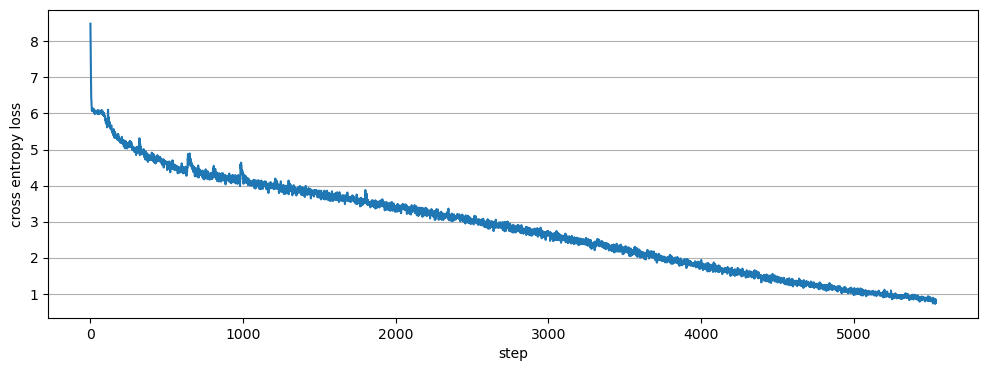

In [9]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(range(len(loss_history["train_loss"])), loss_history["train_loss"])
ax.set_xlabel("step")
ax.set_ylabel("cross entropy loss")
ax.grid(axis="y")

# Play around


In [16]:
# empty prompt to generate random stuff
prompt = torch.full((1, llm_config.seq_len), tokenizer.eos_id, dtype=torch.int32)
prompt = prompt.to(train_config.device)

out = model.generate(prompt, max_seq_len=64)
tokenizer.decode(out.tolist())

"Second Gentleman: What will you give't? LUCIO: Ay, that there's the kiers; And this neared of the deputy, give me his son, that he will not be, if it were a king, To seek a"

In [14]:
# generate from a prompt
prompt = tokenizer.encode(
    "KING HENRY VI:",
    beg_of_string=True,
    pad_seq=True,
    seq_len=llm_config.seq_len,
)
inputs = torch.tensor(prompt, dtype=torch.int32).unsqueeze(0).to(train_config.device)
out = model.generate(inputs, max_seq_len=64)
tokenizer.decode(out.tolist())

"KING HENRY VI: Whate'd the corable, to steal you: In the high of calamity, and with the rest; Forthwith he's father, scorn, pant in them; Between and obsty man, in the mighty father. Why, uncle, here's"